In [1]:
import numpy as np
import pandas as pd
from sklearn import datasets
import matplotlib.pyplot as plt
import matplotlib.colors as mcol
import matplotlib.cm as cm
from matplotlib import colors

from rf import Gini, RandomForest

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Applying a Random Forest to the iris data set

This notebook accompanies this [blog post](www.something.com)

We will use the iris data set to test our model. We will train out model on 80% of the data, and reserve the rest for testing.

To investigate how flexible the decision boundaries we can generate are, we will use a combination of features that does not result in a clear class seperation in feature space. Any learning algorithms would struggle here as there is limited training data and the classes are not well seperated. 

In [2]:
# load data
iris = datasets.load_iris()
X = iris.data
y = iris.target
iris_df = pd.DataFrame(X, columns = ['sl','sw','pl','pw'])
iris_df['species'] = y

In [3]:
# split into train/test
ind = iris_df.index.values
np.random.seed(1234)
train_index = np.random.choice(ind, int(150 * 0.8), replace = False)

iris_train = iris_df.iloc[train_index].sort_index()
iris_test = iris_df.iloc[np.setdiff1d(ind, train_index)].sort_index()

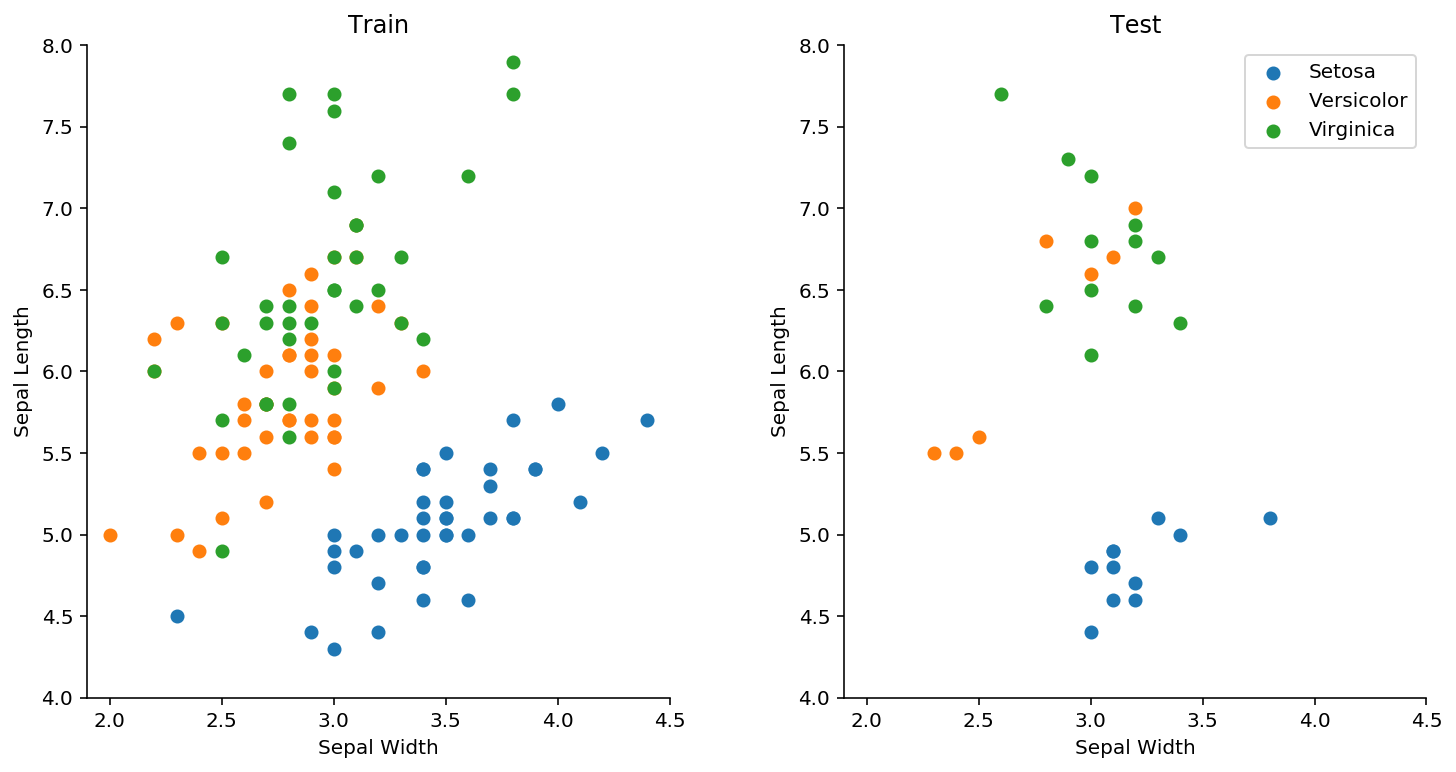

In [4]:
# visualise
f, axarr = plt.subplots(1, 2, figsize = (12,6))
species_map = {0:'Setosa', 1: 'Versicolor', 2:'Virginica'}

for i in range(2):
    axarr[i].spines['top'].set_visible(False)
    axarr[i].spines['right'].set_visible(False)
    axarr[i].set_xlim(1.9, 4.5)
    axarr[i].set_ylim(4.0, 8.0)
    axarr[i].set_xlabel('Sepal Width')
    axarr[i].set_ylabel('Sepal Length')

for _ in iris_train.species.unique():
    tmp = iris_train.loc[iris_df.species == _, :]
    axarr[0].scatter(tmp.sw.values, tmp.sl.values, label = species_map[_])

for _ in iris_test.species.unique():
    tmp = iris_test.loc[iris_df.species == _, :]
    axarr[1].scatter(tmp.sw.values, tmp.sl.values, label = species_map[_])

axarr[1].set_title('Test')
axarr[0].set_title('Train')
axarr[1].legend(loc = 'upper right')

f.subplots_adjust(wspace = 0.3);

# Initial model

Guess the model hyperparameters to investigate the decision boundary we can produce

In [5]:
# initialise rf object and train
rf = RandomForest(ntrees = 100, max_depth = 6, mtry = 1, metric = Gini())
rf.grow_forest(df=iris_train, features = ['sw', 'sl'], target = 'species')

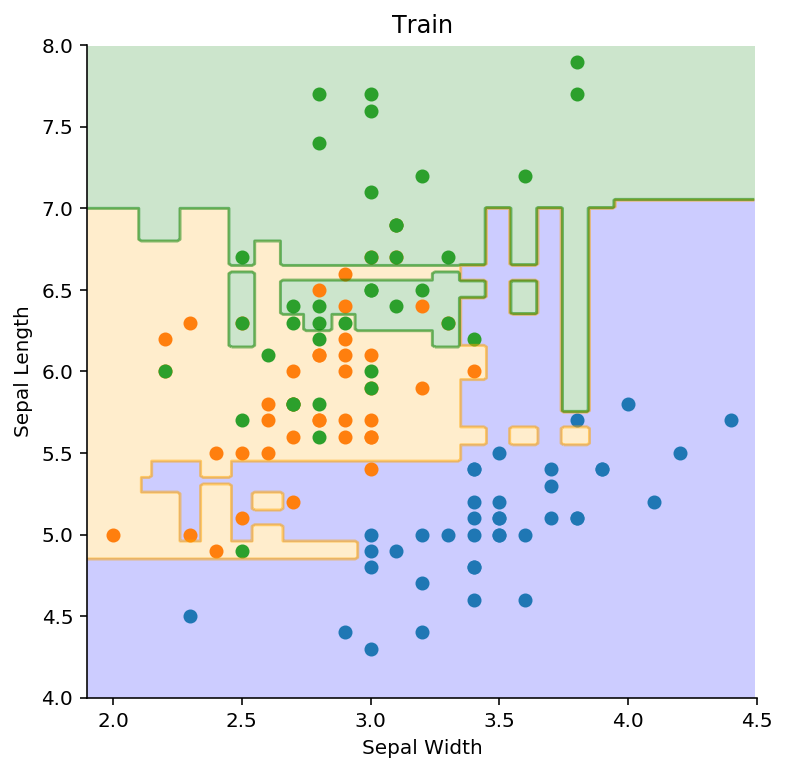

In [6]:
# calculate predictions over full surface
# and visualise
xx, yy = np.meshgrid(np.arange(1.9, 4.5, 0.01),
                     np.arange(4., 8.0, 0.01))

grid_df = pd.DataFrame(np.c_[xx.ravel(), yy.ravel()], columns = ['sw', 'sl'])
grid_df['cls_boundary'] = grid_df.apply(lambda x: rf.predict(x.to_dict()), axis = 1)

# plot two of the features as example- easy to visualise in 2d!
fig, ax = plt.subplots(figsize=(6,6), facecolor='white', edgecolor='white')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.contourf(xx, yy, grid_df.cls_boundary.values.reshape(xx.shape),
             levels = [-1, 0, 1, 2], 
             colors = ('blue', 'orange', 'green'),
             alpha = 0.2)
plt.contour(xx, yy, grid_df.cls_boundary.values.reshape(xx.shape), 
                 levels = [-1, 0, 1, 2],
                 colors = ('blue', 'orange', 'green'), 
                 alpha = 0.5)

for _ in iris_train.species.unique():
    tmp = iris_train.loc[iris_df.species == _, :]
    plt.scatter(tmp.sw.values, tmp.sl.values)
    
plt.xlim(1.9, 4.5)
plt.ylim(4.0, 8.0)
plt.title('Train')
plt.xlabel('Sepal Width')
plt.ylabel('Sepal Length');

We see we have overfit our data with this choice of parameters- we have very flexible decision boundaries, and the overall structure is somewhat reasonable. 

However, many of the smaller regions do not make sense- in some instances we have fitted to single points in the training data, rather than producing classification boundaries that will generalise well.

# Hyperparameter selection

We will implement a simple k-fold cross validation scheme to select our optimal hyperparameters. Once we have determined the best choice of hyperparameters, we will fit the entire training set using these parameters and evaluate the model on the test data set.

In [7]:
def kfold(index, k = 10, seed = 1234):
    '''
    k fold cross validation
    index: index values (np array) from pandas data frame containing training sample
    k: number of folds in cv
    seed: for setting random seed.

    yields: indicies for current fold.
    Note- if using pandas, these are for selection using iloc NOT loc
    '''
    np.random.seed(seed = seed)
    len_index = len(index)
    ind = np.arange(len_index)
    np.random.shuffle(ind)

    for fold in np.array_split(ind, k):
        yield fold

In [8]:
import itertools as it

def expand_grid(param_dict):
    '''
    perform a grid expansion (cartesian product)

    Inputs:
    param_dict: a dictionary with keys as parameter names, values
              as a list of paramter values
    Returns:
    pandas dataframe
    '''
    varNames = sorted(param_dict)
    tmp = [prod for prod in it.product(*(param_dict[varName] for varName in varNames))]
    df = pd.DataFrame(tmp)
    df.columns = varNames
    return df

In [9]:
# initialise a parameter grid, define that we want 3-fold CV
# Note that typically you would select mtry < P  predictive features. As I only have two
# features, I try 1 or 2 features at each branch.
param_grid = expand_grid({'mtry':[1, 2], 'depth':[2, 4, 6, 8], 'n_trees': [10, 25, 50]})
n_hyper_params = param_grid.shape[0]
k = 3

Note that this process is pretty slow. My model implementation is not optimised or written in compiled code, therefore it isnt that fast (we are fitting 2 \* 4 \* 3 \* 3 = 72 models here, based on the hyperparameters and number of folds I have defined). Remember, this is an example for education, not for use in real life! Scikit-Learn has a random forest classifier which you should use instead.

In [10]:
# Perform cross validation

# empty array for holding results
fold_accuracy = np.empty((n_hyper_params, k))

# outer loop over hyperparameter combinations
for row_ix in range(n_hyper_params):
    curr_hyper_params = param_grid.iloc[row_ix].to_dict()
    fold_ix = kfold(iris_train.index.values, k)
    print(row_ix, curr_hyper_params)

    # loop over each 'fold' for CV
    for i in range(k):
        # select holdout and current sample for building model
        curr_holdout_ix = next(fold_ix)
        curr_ix = np.setdiff1d(np.arange(iris_train.shape[0]), curr_holdout_ix)
                
        # build model with current data and hyperparameters
        rf = RandomForest(ntrees = curr_hyper_params['n_trees'], 
                          max_depth = curr_hyper_params['depth'],
                          mtry = curr_hyper_params['mtry'], 
                          metric = Gini())
        rf.grow_forest(df = iris_train.iloc[curr_ix], 
                       features = ['sw', 'sl'], 
                       target = 'species')
        
        # calculate accuracy on holdout:
        acc = np.empty(curr_holdout_ix.shape[0])
        for ix, j in enumerate(curr_holdout_ix):
            outcome = int(iris_train.iloc[j]['species'])
            pred = rf.predict(iris_train.iloc[j][['sw', 'sl']].to_dict())
            acc[ix] = (pred == outcome)
        
        # insert into result array
        fold_accuracy[row_ix, i] = np.sum(acc) / float(acc.shape[0])

0 {'mtry': 1, 'depth': 2, 'n_trees': 10}
1 {'mtry': 1, 'depth': 2, 'n_trees': 25}
2 {'mtry': 1, 'depth': 2, 'n_trees': 50}
3 {'mtry': 2, 'depth': 2, 'n_trees': 10}
4 {'mtry': 2, 'depth': 2, 'n_trees': 25}
5 {'mtry': 2, 'depth': 2, 'n_trees': 50}
6 {'mtry': 1, 'depth': 4, 'n_trees': 10}
7 {'mtry': 1, 'depth': 4, 'n_trees': 25}
8 {'mtry': 1, 'depth': 4, 'n_trees': 50}
9 {'mtry': 2, 'depth': 4, 'n_trees': 10}
10 {'mtry': 2, 'depth': 4, 'n_trees': 25}
11 {'mtry': 2, 'depth': 4, 'n_trees': 50}
12 {'mtry': 1, 'depth': 6, 'n_trees': 10}
13 {'mtry': 1, 'depth': 6, 'n_trees': 25}
14 {'mtry': 1, 'depth': 6, 'n_trees': 50}
15 {'mtry': 2, 'depth': 6, 'n_trees': 10}
16 {'mtry': 2, 'depth': 6, 'n_trees': 25}
17 {'mtry': 2, 'depth': 6, 'n_trees': 50}
18 {'mtry': 1, 'depth': 8, 'n_trees': 10}
19 {'mtry': 1, 'depth': 8, 'n_trees': 25}
20 {'mtry': 1, 'depth': 8, 'n_trees': 50}
21 {'mtry': 2, 'depth': 8, 'n_trees': 10}
22 {'mtry': 2, 'depth': 8, 'n_trees': 25}
23 {'mtry': 2, 'depth': 8, 'n_trees': 50}


In [11]:
# we take the hyperparameters that give the best average
# accuracy as the best choice
fold_accuracy.mean(axis = 1).argmax()

22

In [4]:
# we then grow a tree using best params for entire training set
rf = RandomForest( ntrees = 25, max_depth = 8, mtry = 2, metric = Gini())
rf.grow_forest(df=iris_df, features = ['sw', 'sl'], target = 'species')

# Predictions on the test set with our fitted model

This will give us some idea how our model will generalise. 

Do remember though, that the test set is quite small, so it is likely that results would fluctuate if the training set was a different 80% of the data. In fact, you could consider keeping all the data in the training set, and implementing a more thorough cross validation scheme to approximate how well the model will generalise to new data

In [10]:
# pred test set:
iris_test['pred'] = iris_test.apply(lambda x: rf.predict(x.to_dict()), axis = 1)

# accuracy of final model on test set
pred_correct = (iris_test.species.values == iris_test.pred.values).sum()
total_samples =  iris_test.shape[0]

acc = pred_correct / total_samples

print('Test accuracy: {:.3f}'.format(acc))
# do a confusion matrix too

Test accuracy: 0.833


# Hard classification boundaries

With our choice of parameters, lets look at the decision boundaries.

We will also consider a 'region of uncertainty', that is, where the class with the highest proportion of votes has less than 50% of the votes. We could argue that we arent certain enough to make predictions in this region.

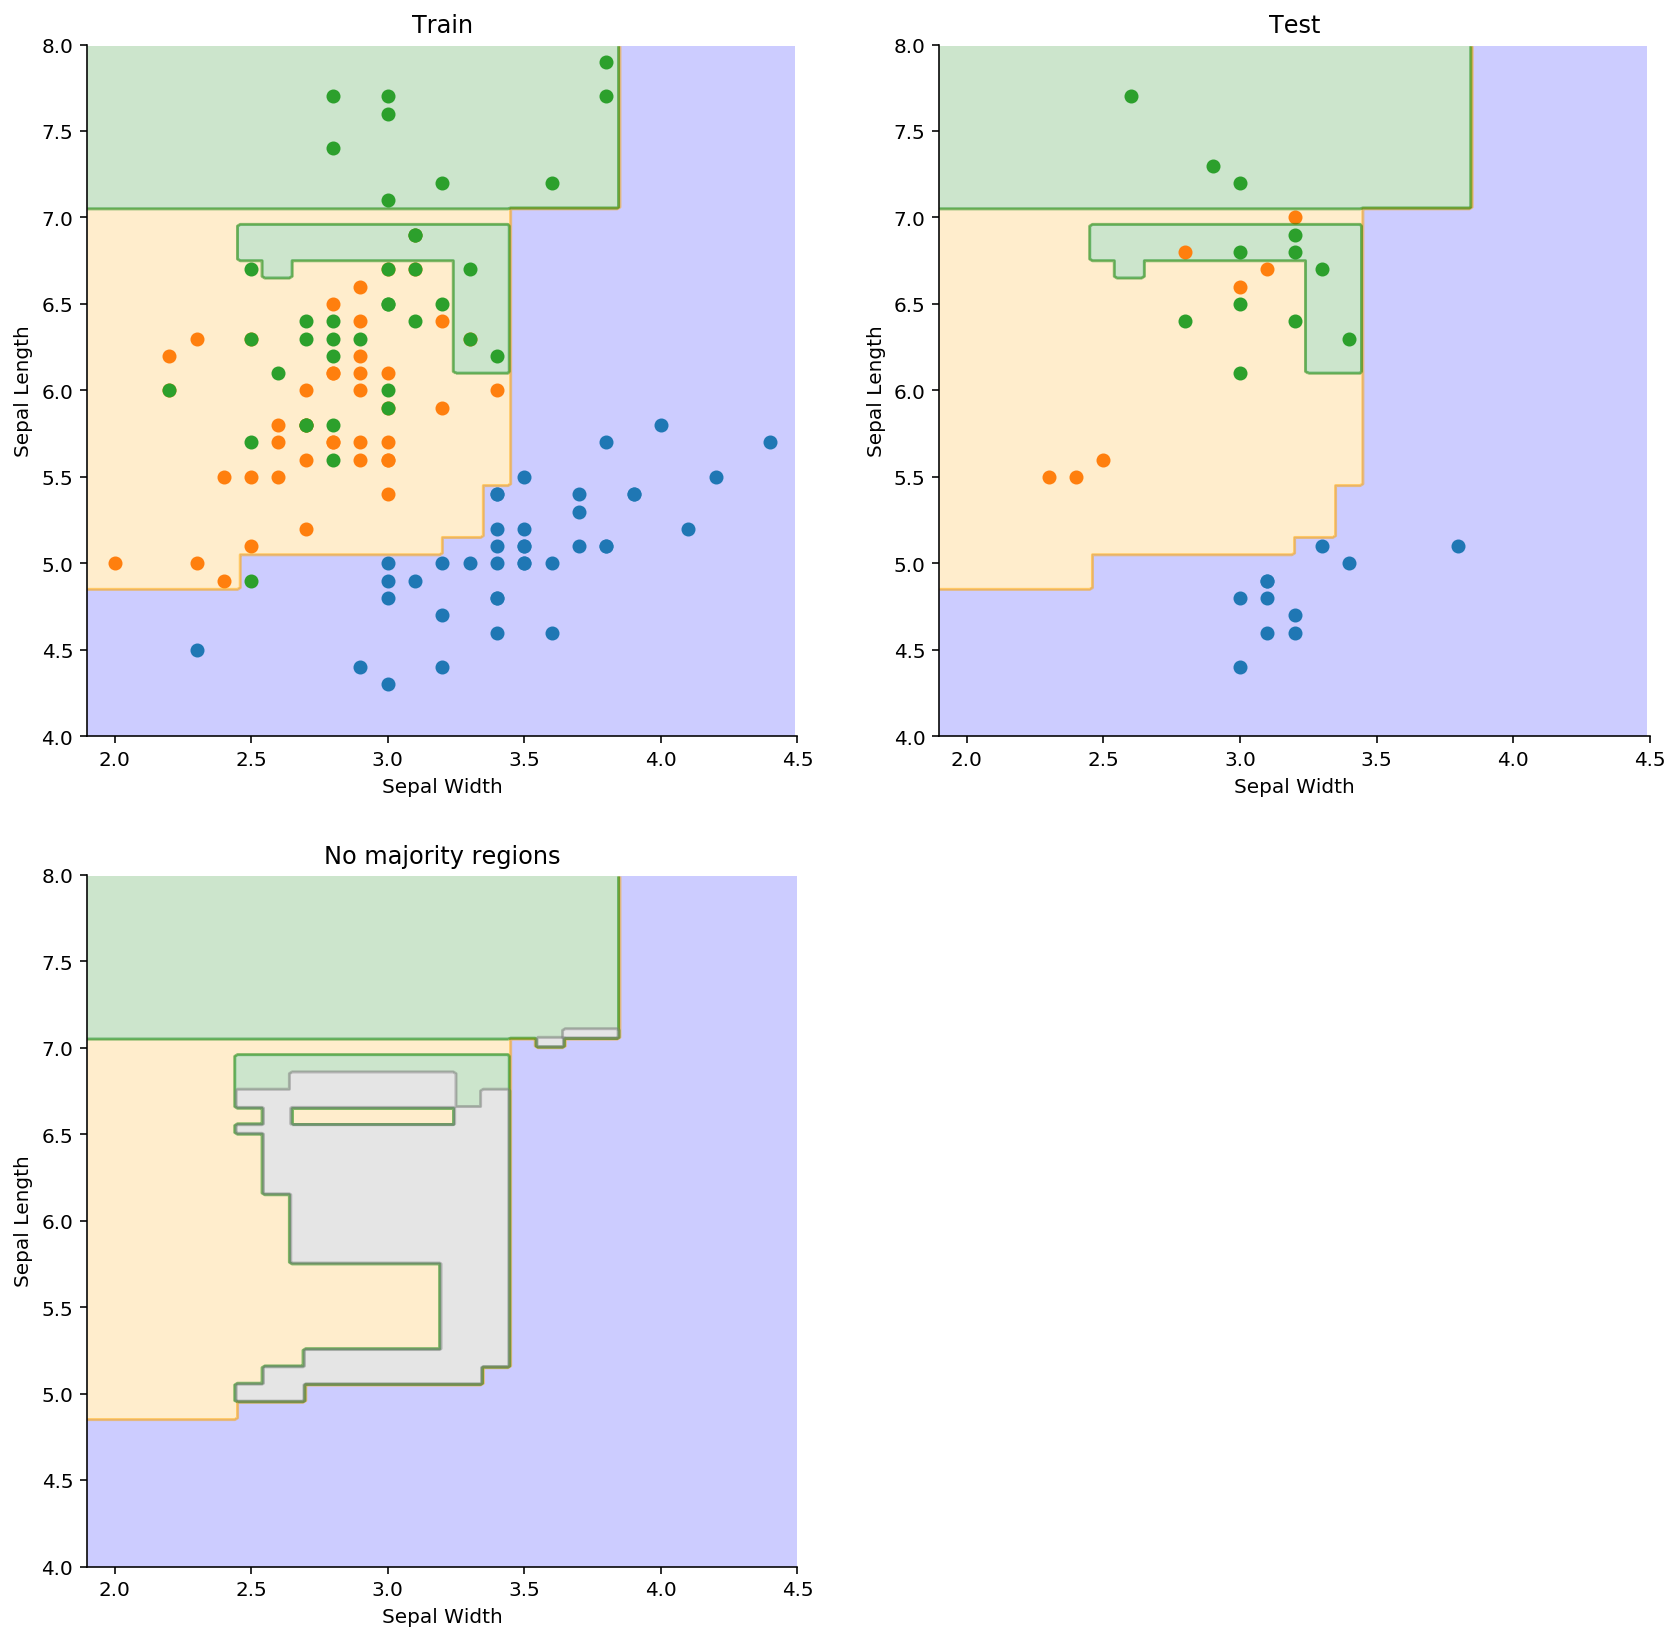

In [27]:
f, axarr = plt.subplots(2, 2, figsize = (14,14))
species_map = {0:'Setosa', 1: 'Versicolor', 2:'Virginica'}

for i in range(2):
    for j in range(2):
        axarr[i,j].spines['top'].set_visible(False)
        axarr[i,j].spines['right'].set_visible(False)
        axarr[i,j].set_xlim(1.9, 4.5)
        axarr[i,j].set_ylim(4.0, 8.0)
        axarr[i,j].set_xlabel('Sepal Width')
        axarr[i,j].set_ylabel('Sepal Length')
        
axarr[1,1].axis('off')

xx, yy = np.meshgrid(np.arange(1.9, 4.5, 0.01),
                     np.arange(4., 8.0, 0.01))

grid_df = pd.DataFrame(np.c_[xx.ravel(), yy.ravel()], columns = ['sw', 'sl'])
grid_df['cls_boundary'] = grid_df.apply(lambda x: rf.predict(x.to_dict()), axis = 1)

for i in range(2):
    axarr[0,i].contourf(xx, yy, grid_df.cls_boundary.values.reshape(xx.shape),
                 levels = [-1, 0, 1, 2], colors = ('blue', 'orange', 'green'),
                 alpha = 0.2)

    axarr[0,i].contour(xx, yy, grid_df.cls_boundary.values.reshape(xx.shape), 
                levels = [-1, 0, 1, 2],
                colors = ('blue', 'orange', 'green'), 
                alpha = 0.5)

for _ in iris_train.species.unique():
    tmp = iris_train.loc[iris_df.species == _, :]
    axarr[0,0].scatter(tmp.sw.values, tmp.sl.values)
    
for _ in iris_test.species.unique():
    tmp = iris_test.loc[iris_df.species == _, :]
    axarr[0,1].scatter(tmp.sw.values, tmp.sl.values)
    
    
xx, yy = np.meshgrid(np.arange(1.5, 5.0, 0.01),
                     np.arange(4., 8.0, 0.01))

grid_df = pd.DataFrame(np.c_[xx.ravel(), yy.ravel()], columns = ['sw', 'sl'])
grid_df['cls_boundary'] = grid_df.apply(lambda x: rf.predict(x.to_dict(), no_majority =True), axis = 1)

axarr[1,0].contourf(xx, yy, grid_df.cls_boundary.values.reshape(xx.shape),
             levels = [-1, 0, 1, 2, 3], 
             colors = ('blue', 'orange', 'green', 'grey'), 
             alpha = 0.2)

axarr[1,0].contour(xx, yy, grid_df.cls_boundary.values.reshape(xx.shape), 
            levels = [-1, 0, 1, 2, 3],
            colors = ('blue', 'orange', 'green', 'grey'), 
            alpha = 0.5);

axarr[0,0].set_title('Train')
axarr[0,1].set_title('Test')
axarr[1,0].set_title('No majority regions')

f.subplots_adjust(wspace = 0.2)
f.subplots_adjust(hspace = 0.2);
#f.savefig('regions.png', bbox_inches = 'tight')

We see in the left and center figure that our model looks much better- we arent overfitting as aggressively as beforehand. In the right hand planel, we arent suprised to see the large region in the center where the majority class has less than 50% of the votes. This is understandable, as there is a large amount of overlap between two of the classes If we were gambling, we wouldnt be very confident to bet on the species in this region. 

We will investigate 'probabilities' rather than hard classifications next.

# Class 'probability' surface

We can naively interpret the voting produced by our trees as a probability if we consider the proportion of votes to each class (there are ways to investigate how well calibrated this 'probability' is, and to perform an adjustment so that it is reasonable to interpret as a probability. We wont consider that here, though).

Lets plot the probabilities rather than hard classifications for each class

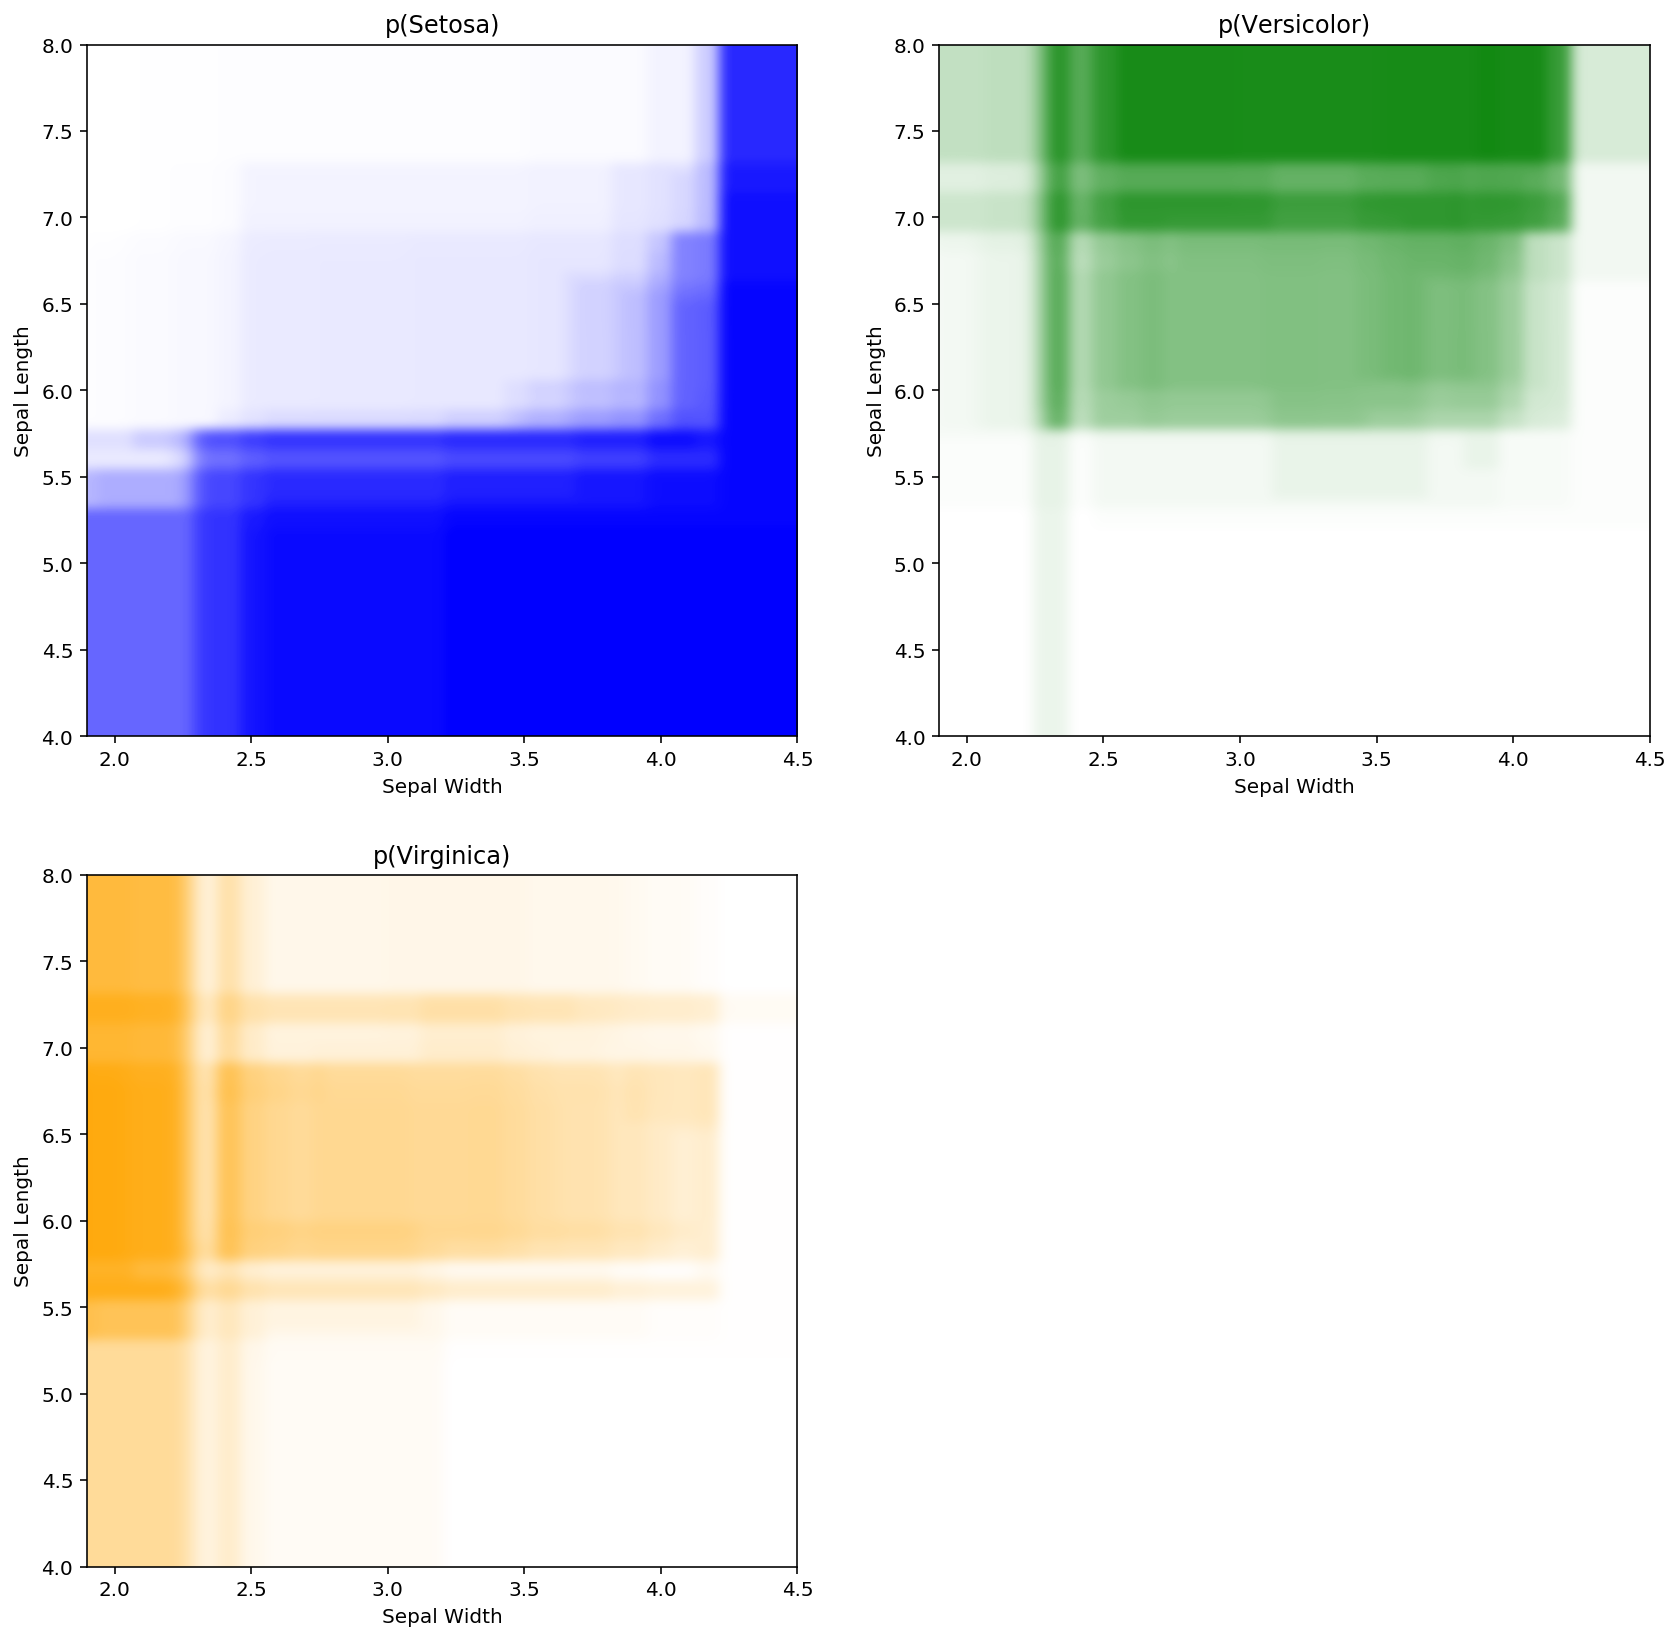

In [23]:
# Rather hacky matplotlib skills here to visualise 
# probabilities over feature space

xx, yy = np.meshgrid(np.arange(1.5, 5.0, 0.05),
                     np.arange(4., 8.0, 0.05))

f, axarr = plt.subplots(2, 2, figsize = (14,14))

for i in range(2):
    for j in range(2):
        axarr[i,j].set_xlim(1.9, 4.5)
        axarr[i,j].set_ylim(4.0, 8.0)
        axarr[i,j].set_xlabel('Sepal Width')
        axarr[i,j].set_ylabel('Sepal Length')

axarr[1,1].axis('off')

axarr[0,0].set_title('p(Setosa)')
axarr[0,1].set_title('p(Versicolor)')
axarr[1,0].set_title('p(Virginica)');    
    
# plot 1    
# Make a user-defined colormap.
cm1 = mcol.LinearSegmentedColormap.from_list("cmap1",["white","blue"])
# Make a normalizer
cnorm = mcol.Normalize(vmin=0,vmax=1)
# Turn these into an object that can be used to map time values to colors and
# can be passed to plt.colorbar().
cpick = cm.ScalarMappable(norm=cnorm,cmap=cm1)
cpick.set_array([])

grid_df = pd.DataFrame(np.c_[xx.ravel(), yy.ravel()], columns = ['sw', 'sl'])
grid_df['cls_boundary'] = grid_df.apply(lambda x: rf.predict(x.to_dict(), predict_proba=True)[0], axis = 1)

im = axarr[0,0].imshow(np.fliplr(grid_df['cls_boundary'].values.reshape(80, 70).T),
           extent = [1.5, 5, 4.0, 8.0], vmax = 1.0, vmin =0.0,
          cmap = cm1, interpolation='bicubic', aspect='auto')
#f.colorbar(im, ax=axarr[1,])

# plot2 
cm2 = mcol.LinearSegmentedColormap.from_list("cmap1",["white","green"])
cnorm = mcol.Normalize(vmin=0,vmax=1)
cpick = cm.ScalarMappable(norm=cnorm,cmap=cm2)
cpick.set_array([])

grid_df = pd.DataFrame(np.c_[xx.ravel(), yy.ravel()], columns = ['sw', 'sl'])
grid_df['cls_boundary'] = grid_df.apply(lambda x: rf.predict(x.to_dict(), predict_proba=True)[1], axis = 1)

im = axarr[0,1].imshow(np.fliplr(grid_df['cls_boundary'].values.reshape(80, 70).T),
           extent = [1.5, 5, 4.0, 8.0], vmax = 1.0, vmin =0.0,
           cmap = cm2, interpolation='bicubic', aspect = 'auto')
#f.colorbar(im, ax=axarr[1,1]);

#plot 3
cm3 = mcol.LinearSegmentedColormap.from_list("cmap1",["white","orange"])
cnorm = mcol.Normalize(vmin=0,vmax=1)
cpick = cm.ScalarMappable(norm=cnorm,cmap=cm3)
cpick.set_array([])

grid_df = pd.DataFrame(np.c_[xx.ravel(), yy.ravel()], columns = ['sw', 'sl'])
grid_df['cls_boundary'] = grid_df.apply(lambda x: rf.predict(x.to_dict(), predict_proba=True)[2], axis = 1)

im = axarr[1,0].imshow(np.fliplr(grid_df['cls_boundary'].values.reshape(80, 70).T),
           extent = [1.5, 5, 4.0, 8.0], vmax = 1.0, vmin =0.0,
          cmap = cm3, interpolation='bicubic', aspect = 'auto')
#f.colorbar(im, ax=axarr[1,1]);
#f.savefig('probabilities.png', bbox_inches = 'tight')

As we can see (using slightly hacky matplotlib skills), we see opaque regions that correspond with higher certainty of a class in a region, and transparent regions where we have far less confidence in our predictions. Most obvious is our central regioon where we have about the same confidence of predicting versicolor as virginica, but also have a very small probability of the class being Setosa. Therefore, we have less than a proportion of 0.5 of votes in this region.

# Conclusion

We implemented a random forest model and fitted it to a dataset using cross validation to select optimal hyperparameters. We the investigated hard classification boundaries, and the pseudo-probabilities over feature space that the model produces.

This has been a fun excercise, and has given me a lot more insight as to how a random forest model actually works, rather than just relying on Scikit-Learn's API doing some magic for me. I think it is important to have a good understanding of the models you apply to ensure that you can interpret them, and that you are using an appropriate tool for the job.

Do remember though, that this code is for educational purposes- it is far from being optimised, and you are much better off using well established, optimised code libraries when building learning algorithms!